# Introduction and Loading Dataset

This project attempts to implement and train a YOLO (You Only Look Once) Object Detection model on the COCO 2017 dataset.


In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import pylab
from zipfile import ZipFile, BadZipFile
import os
import pathlib
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from __future__ import division

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import cv2
import time
import pickle as pkl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# downloading the datasets

# !wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

# ROOT = "./coco"
# IMAGES_PATH = str(ROOT + "/images")
# ANNOTATIONS_PATH = str(ROOT + "/instances.json")

# dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH)

In [ ]:
from google.colab import drive
# run once to mount drive
# drive.mount('/content/drive')

In [11]:
# Move files from drive, run if files are not already in root folder
!cp "/content/drive/MyDrive/Coco Datasets/coco_ann2017.zip" "."
!cp "/content/drive/MyDrive/Coco Datasets/coco_val2017.zip" "."

In [16]:
# extract zip files
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

In [17]:
# extract_train_path = "./coco_train2017"
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"
# extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

In [13]:
dataDir='./coco_ann2017'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [18]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=31.59s)
creating index...
index created!


In [3]:
# Display image using the given image and (optionally) annotation

def show_coco_image(image, annotations = None):
  # Retrieve image dimensions
  height, width = image['height'], image['width']

  # Create a new figure with the same dimensions as the image
  fig, ax = plt.subplots(figsize=(10,10), dpi=100)

  I = io.imread(image['coco_url'])
  # Display the original image
  ax.imshow(I)
  ax.axis('off')
  ax.set_title("Image ID: {}".format(image["id"]))

  # Draw bounding boxes on the original image
  if (annotations):
    for annotation in annotations:
        bbox = annotation['bbox']
        category_id = annotation['category_id']
        category_name = coco.loadCats(category_id)[0]['name']

        # Convert COCO bounding box format (x, y, width, height) to matplotlib format (xmin, ymin, xmax, ymax)
        xmin, ymin, width, height = bbox
        xmax = xmin + width
        ymax = ymin + height

        # Draw the bounding box rectangle
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Add the category name as a label above the bounding box
        ax.text(xmin, ymin - 5, category_name, fontsize=8, color='red', weight='bold')

# Show the plot
  plt.show()
# Clear plot after showing
  ax.clear()
  plt.clf()
  plt.cla()
  plt.close()

def show_image(image):

  # Create a new figure with the same dimensions as the image
  fig, ax = plt.subplots(figsize=(10,10), dpi=100)

  # Display image
  ax.imshow(image)
  ax.axis('off')

# Show the plot
  plt.show()
# Clear plot after showing
  ax.clear()
  plt.clf()
  plt.cla()
  plt.close()

In [ ]:
# helpers for acquiring annotations

# return a list of annotations for a specific image id
'''
@param dict: a dictionary containing the annotations of images
@param image: an image we want to find annotations for
@return A list of annotations (bounding box + category)
'''
def get_annotations_for_image(dict, image):
  return list(dict[image["id"]].values())[0]

'''
@param data: an image set following Coco file format
@return a 2d dictionary where an image id is associated with a dictionary object that contains all annotations related to that id
'''
def create_label_dict(data):
  data_id = np.array([d["id"] for d in data])

  labelled_data = coco.loadAnns(coco.getAnnIds(imgIds = data_id))
  label_dict = {}
  for labels in labelled_data:
    image_id = labels['image_id']

    if (image_id not in label_dict):
      label_dict[image_id] = {}
      label_dict_entry = label_dict[image_id]
      label_dict_entry["annotations"] = []

    label_dict_entry = label_dict[image_id]
    annotation_entry = {"id": labels["id"], "category_id": labels["category_id"], "bbox": labels["bbox"]}
    label_dict_entry["annotations"].append(annotation_entry)

  return label_dict

In [7]:
# General initialization
# use official cfg file
!mkdir cfg
!cd cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

# use official weight file
!wget https://pjreddie.com/media/files/yolov3.weights

--2024-05-31 06:44:08--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-05-31 06:44:08 (51.4 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2024-05-31 06:44:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  34.2MB/s    in 8.1s    

2024-05-31 06:4

In [4]:
# utilities



def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)

    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res


def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes


    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)

    #Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area)

    return iou

def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask

    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2)
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]

    batch_size = prediction.size(0)

    write = False



    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
       #confidence threshholding
       #NMS

        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)

        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except:
            continue

        if image_pred_.shape[0] == 0:
            continue
#

        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1])  # -1 index holds the class index


        for cls in img_classes:
            #perform NMS


            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)

            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)   #Number of detections

            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at
                #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break

                except IndexError:
                    break

                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask

                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)

            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class

            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    try:
        return output
    except:
        return 0

def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)

    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image

    return canvas

def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network.

    Returns a Variable
    """
    img = (letterbox_image(img, (inp_dim, inp_dim)))
    img = img[:,:,::-1].transpose((2,0,1)).copy()
    img = torch.from_numpy(img).float().div(255.0).unsqueeze(0)
    return img

def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

In [5]:
def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):

    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    # grid_size = inp_dim // stride
    grid_size = prediction.size(2)
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    # print(grid_size*grid_size)
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])

    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors

    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride

    return prediction

In [6]:
# Darknet-53

def parse_cfg(cfgfile):
    """
    Takes a configuration file

    Returns a list of blocks. Each blocks describes a block in the neural
    network to be built. Block is represented as a dictionary in the list

    """

    file = open(cfgfile, 'r')
    lines = file.read().split('\n')                        # store the lines in a list
    lines = [x for x in lines if len(x) > 0]               # get read of the empty lines
    lines = [x for x in lines if x[0] != '#']              # get rid of comments
    lines = [x.rstrip().lstrip() for x in lines]           # get rid of fringe whitespaces

    block = {}
    blocks = []

    for line in lines:
        if line[0] == "[":               # This marks the start of a new block
            if len(block) != 0:          # If block is not empty, implies it is storing values of previous block.
                blocks.append(block)     # add it the blocks list
                block = {}               # re-init the block
            block["type"] = line[1:-1].rstrip()
        else:
            key,value = line.split("=")
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)

    return blocks


class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()


class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors



def create_modules(blocks):
    net_info = blocks[0]     #Captures the information about the input and pre-processing
    module_list = nn.ModuleList()
    prev_filters = 3
    output_filters = []

    for index, x in enumerate(blocks[1:]):
        module = nn.Sequential()

        #check the type of block
        #create a new module for the block
        #append to module_list

        #If it's a convolutional layer
        if (x["type"] == "convolutional"):
            #Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True

            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])

            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0

            #Add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)

            #Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)

            #Check the activation.
            #It is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)

            #If it's an upsampling layer
            #We use Bilinear2dUpsampling
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
            upsample = nn.Upsample(scale_factor = 2, mode = "nearest")
            module.add_module("upsample_{}".format(index), upsample)

        #If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            #Start  of a route
            start = int(x["layers"][0])
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
            #Positive anotation
            if start > 0:
                start = start - index
            if end > 0:
                end = end - index
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]

        #shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)

        #Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]

            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]

            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)

        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)

    return (net_info, module_list)

class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_modules(self.blocks)

    def forward(self, x, CUDA):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer

        write = 0
        for i, module in enumerate(modules):
            module_type = (module["type"])

            if module_type == "convolutional" or module_type == "upsample":
                x = self.module_list[i](x)

            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]

                if (layers[0]) > 0:
                    layers[0] = layers[0] - i

                if len(layers) == 1:
                    x = outputs[i + (layers[0])]

                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i

                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)


            elif  module_type == "shortcut":
                from_ = int(module["from"])
                x = outputs[i-1] + outputs[i+from_]

            elif module_type == 'yolo':
                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int (self.net_info["height"])

                #Get the number of classes
                num_classes = int (module["classes"])

                #Transform
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                if not write:              #if no collector has been intialised.
                    detections = x
                    write = 1

                else:
                    detections = torch.cat((detections, x), 1)

            outputs[i] = x

        return detections


    def load_weights(self, weightfile):
        #Open the weights file
        fp = open(weightfile, "rb")

        #The first 5 values are header information
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number
        # 4,5. Images seen by the network (during training)
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]

        weights = np.fromfile(fp, dtype = np.float32)

        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]

            #If module_type is convolutional load weights
            #Otherwise ignore.

            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0

                conv = model[0]


                if (batch_normalize):
                    bn = model[1]

                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()

                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases

                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases

                    #Cast the loaded weights into dims of model weights.
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)

                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)

                else:
                    #Number of biases
                    num_biases = conv.bias.numel()

                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases

                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)

                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)

                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()

                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights

                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)

In [23]:
def evaluate(image_set):
  model = Darknet("cfg/yolov3.cfg")
  model.load_weights("yolov3.weights")
  #!wget https://github.com/ayooshkathuria/pytorch-yolo-v3/raw/master/dog-cycle-car.png

  num_classes = len(coco.getCatIds())

  classes = []

  for data in coco.loadCats(coco.getCatIds()):
    classes.append(data["name"])

  batch_size = 1
  confidence = 0.5
  nms_thesh = 0.4
  start = 0
  CUDA = torch.cuda.is_available()

  if CUDA:
    model.cuda()

  # model.eval()

  inp_dim = int(model.net_info["height"])
  assert inp_dim % 32 == 0
  assert inp_dim > 32

  #PyTorch Variables for images
  loaded_ims = [io.imread(x["coco_url"]) for x in image_set]

  im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(image_set))]))
  im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
  im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)

  if CUDA:
      im_dim_list = im_dim_list.cuda()


  leftover = 0
  if (len(im_dim_list) % batch_size):
    leftover = 1

  if batch_size != 1:
    num_batches = len(image_train_set) // batch_size + leftover
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]

  write = 0
  start_det_loop = time.time()
  for i, batch in enumerate(im_batches):
      #load the image
      start = time.time()
      if CUDA:
          batch = batch.cuda()

      prediction = model(Variable(batch, volatile = True), CUDA)

      prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

      end = time.time()

      if type(prediction) == int:

          for im_num, image in enumerate(image_train_set[i*batch_size: min((i +  1)*batch_size, len(image_set))]):
              im_id = i*batch_size + im_num
              print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
              print("{0:20s} {1:s}".format("Objects Detected:", ""))
              print("----------------------------------------------------------")
          continue

      prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist

      if not write:                      #If we have't initialised output
          output = prediction
          write = 1
      else:
          output = torch.cat((output,prediction))

      for im_num, image in enumerate(image_set[i*batch_size: min((i +  1)*batch_size, len(image_set))]):
          im_id = i*batch_size + im_num
          objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]

      if CUDA:
          torch.cuda.synchronize()

  try:
      output
  except NameError:
      print ("No detections were made")
      exit()

  im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

  scaling_factor = torch.min(416/im_dim_list,1)[0].view(-1,1)


  output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
  output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2



  output[:,1:5] /= scaling_factor

  for i in range(output.shape[0]):
      output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
      output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])


  output_recast = time.time()
  class_load = time.time()
  # colors = pkl.load(open("pallete", "rb"))

  def write(x, results):
      c1 = tuple((int(x[1].item()), int(x[2].item())))
      c2 = tuple((int(x[3].item()), int(x[4].item())))

      img = results[int(x[0])]

      color = (int(np.random.randn() * 255), int(np.random.randn() * 255), int(np.random.randn() * 255))
      cls = int(x[-1])
      label = "{0}".format(classes[cls])
      cv2.rectangle(img, c1, c2,color, 1)
      t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
      c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
      cv2.rectangle(img, c1, c2, color, -1)
      cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
      return img

  draw = time.time()
  list(map(lambda x: write(x, loaded_ims), output))

  for img in loaded_ims:
    show_image(img)

  torch.cuda.empty_cache()


<ipython-input-23-df14ca1ed40c>:56: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  prediction = model(Variable(batch, volatile = True), CUDA)


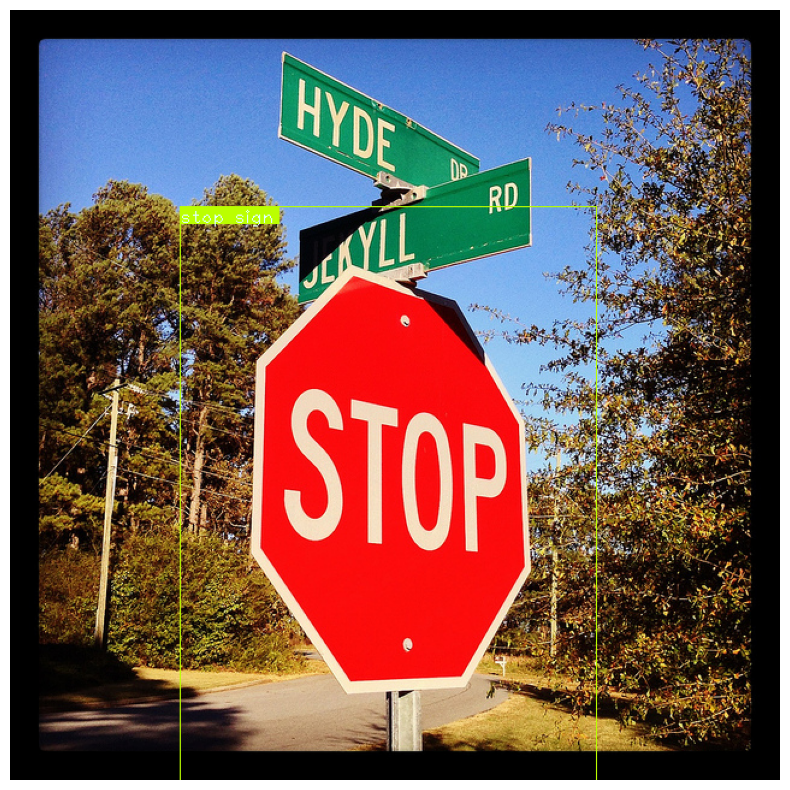

In [32]:
# load categories and images from annotated training sets;
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds)

images = np.array([imgs[int(np.random.randn() * 10000)]])

evaluate(images)